# Метод главных компонент
**источник: <a href='https://habr.com/ru/post/507618/'>Статья Александра Петренко «Метод главных компонент: аналитическое решение», Хабр, 2020</a>**



Существует такое предположение, что чем больше дисперсия значений рассматриваемого признака $x_j$ в матрице $X$, тем более значим признак для объяснения значений целевой переменной $\vec{y}$, естественно, при условии масштабированности признакового пространства. Данное предположение появилось вследствии еще одного, не менее загадочного предположения о том, что дисперсия, являющаяся мерой изменчивости данных, может отражать уровень их информативности.

Мы смоделируем матрицу исходных признаков $X$, для нее определим вектор истинных ответов $\vec{y}$, преобразуем методом главных компонент матрицу $X$ в матрицу $Z$, обучим модель линейной регрессии на двух матрицах данных, сравним качество моделей, определим статистики, характеризующие матрицы $X$ и $Z$.

Сгенерируем 5000 объетов. Пусть это будут какие-то абстрактные изделия, например, муфты металлические соединительные.

Давайте определимся как мы будем генерировать эти 5000 объектов в матрице $X$

Для каждого изделия сгенеририруем 4 признака $x_{j}$. Пусть это будут длина изделия — $x_1$, диаметр изделия — $x_2$ и еще два признака, которые являются производными от первых двух и содержат много шума, поэтому они малоинформативны, мы их так и будем называть: 3-й и 4-й признаки, соответственно $x_3$ и $x_4$.

С целью установления связи между первыми двумя признаками, при генерации данных, используем параметры их матрицы ковариации $\Sigma_{x_1x_2}$: дисперсии и коэффициенты ковариации. Первому признаку — длине изделия, зададим наибольшую дисперсию.

Теперь определим вектор истинных значений целевой переменной $\vec{y}$.

Для генерации истинных значений целевой переменной $\vec{y}$ воспользуемся следующей формулой:
$ \vec{y} = XR^T$


, где $R$ — это вектор коэффициентов, определяющий силу влияния значений признаков в формировании истинных ответов

$X$ — это наша матрица исходного признакового пространства

Как следует из формулы, каждый признак вносит свой собственный вклад в определении значений истинных ответов, в соответствии с заданными коэффициентами. При определении коэффициентов мы закладываем логику, что длина и диаметр должны в большей степени определять вес изделия, нежели 3-й и 4-й признаки. Также мы увязываем значения коэффициентов с размерами дисперсий признаков, но весьма экстравагантным способом:


$R = (1.3 \quad 1.3 \quad 0.33 \quad 0.33)$

$\sigma_1^2 \approx 2.0$, $r_1 \approx \frac{1}{2}(\sigma_1^2 + \sigma_2^2) \approx 1.3$

$\sigma_2^2 \approx 0.6$, $r_2 \approx \frac{1}{2}(\sigma_1^2 + \sigma_2^2) \approx 1.3$

$\sigma_3^2 \approx 0.3$, $r_3 \approx \frac{1}{8}(r_1+r_2) \approx 0.33$

$\sigma_4^2 \approx 0.1$, $r_4 \approx \frac{1}{8}(r_1+r_2) \approx 0.33$

где $\sigma_j$ — значение дисперсии соответствующей $j$-му признаку, $r_j$ — значение коэффициента соответствующего $j$-му признаку.

In [1]:
# импортируем библиотеки
import numpy as np
import pandas as pd

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns; sns.set()

import random

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

In [2]:
np.random.seed(0)
# инициализируем математическое ожидание двух случайных величин (признаки: длина и диаметр изделия)
mu = np.array((100.,100))
# инициализируем матрицу ковариации двух случайных величин (признаки: длина и диаметр изделия)
cov = np.array([[1.3,0.15],[0.6,0.8]])
# где 00 — Vx, 11 — Vy, 01 (0.15) — Cxy, 10 (0.6) — Cyx
cov

array([[1.3 , 0.15],
       [0.6 , 0.8 ]])

In [3]:
# инициализируем количество объектов
N = 5000
# формируем матрицу признаков с параметрами mu (среднее) и cov
X12 = np.dot(np.random.randn(N, 2), cov) + mu
# выделяем из матрицы X12 1-й вектор значений признаков
x1 = X12[:,0]
# выделяем из матрицы X12 2-й вектор значений признаков
x2 = X12[:,1]
# формируем шум для 3-го вектора значений признаков и смещаем среднее
e3 = np.array([random.uniform(49.05,50.95) for i in range(N)])
# формируем 3-й вектор значений признаков
x3 = (x1/3 + x2/10)/5 + e3
# формируем шум для 4-го вектора значений признаков и смещаем среднее
e4 = np.array([random.uniform(350.5,351.5) for i in range(N)])
# формируем 4-й вектор значений признаков
x4 = (x1/100 + x2*2)/10 + e4

# формируем матрицу исходного признакового пространства
X = np.vstack((np.vstack((np.vstack((x1,x2)),x3)),x4)).T

# записываем правило определения истинных значений целевой переменной
def y(X, r_0, R):
    R = R.reshape(-1, R.shape[0])
    e = np.array([random.uniform(-1.,1.) for i in range(N)]).reshape(-1,1)
    y = r_0 + np.dot(X, R.T) + e
    return y

# инициализируем вектор коэффициентов
r_0 = 0
R = np.array([1.3, 1.3, 0.33, 0.33])
# формируем вектор истинных значений
y = y(X, r_0, R)

# формируем таблицу pandas с исходными данными матрицы X и вектора y
dataframe = pd.DataFrame(X)
columns_x = ['Длина, мм', 'Диаметр, мм', '3-й признак', '4-й признак']
dataframe = pd.DataFrame(np.hstack((X,y)))
dataframe.columns = columns_x + ['Вес изделия']

In [4]:
x1[:3]

array([102.53336237, 102.6168953 , 101.84145866])

In [5]:
dataframe.head(3)

,"Длина, мм","Диаметр, мм",3-й признак,4-й признак,Вес изделия
0,102.533362,100.584734,59.142109,371.475187,405.579927
1,102.616895,101.939525,58.084921,371.198823,407.822051
2,101.841459,99.498311,57.925020,371.301633,403.122740


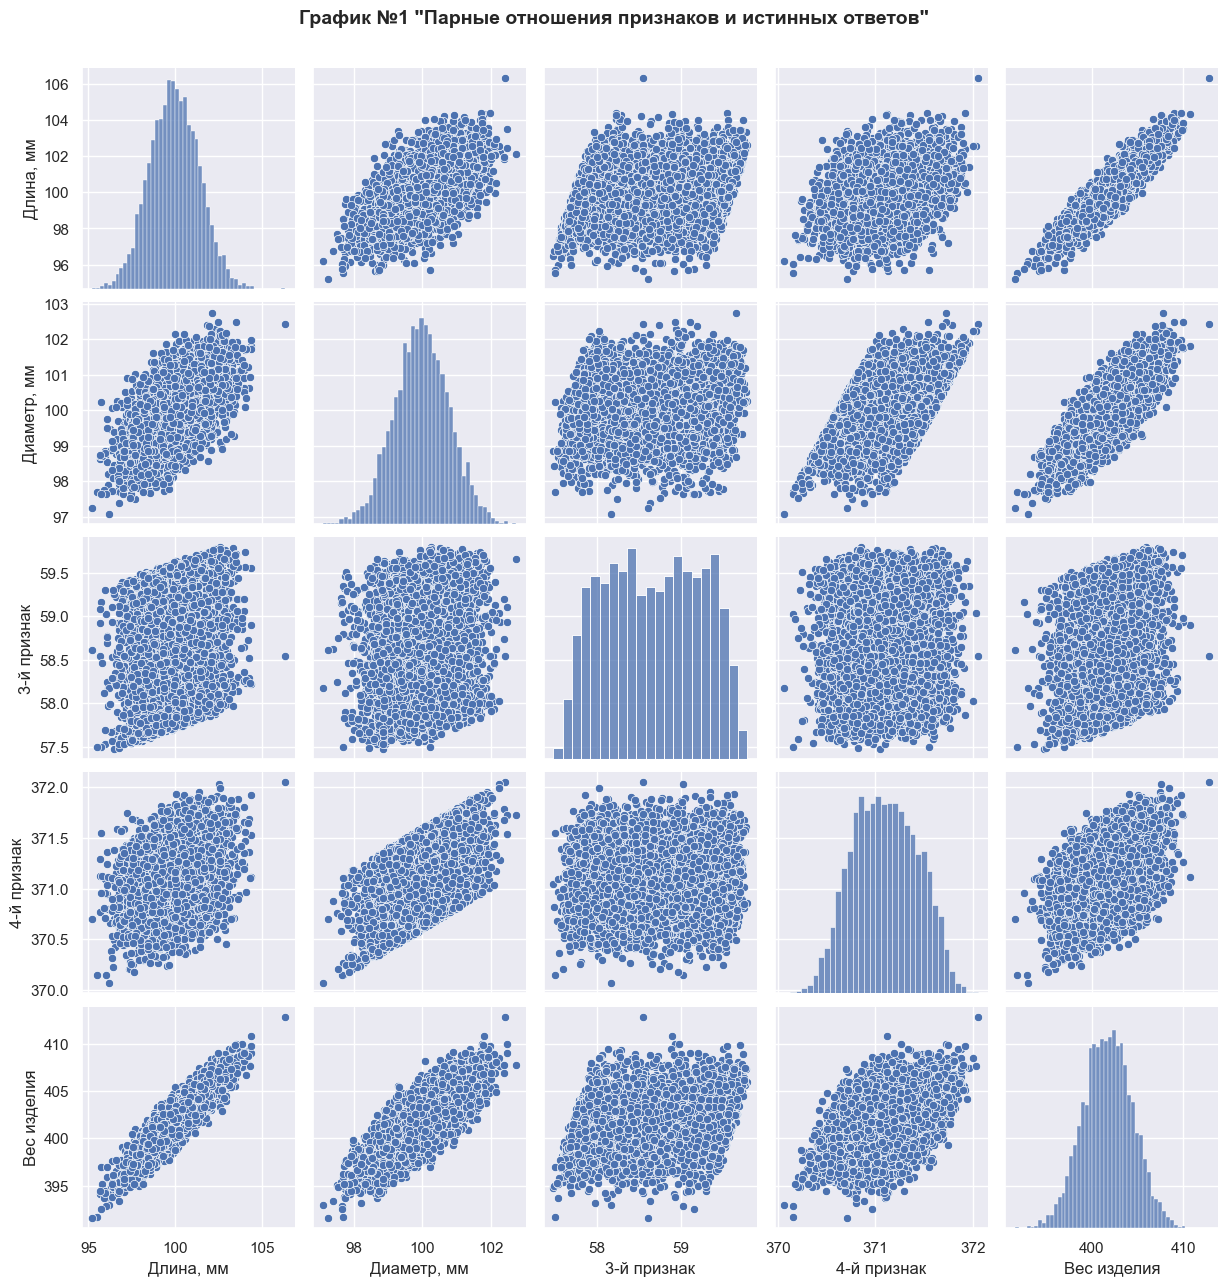

In [6]:
# print ('График №1 "Парные отношения признаков и истинных ответов"')
sns_plot = sns.pairplot(dataframe)
sns_plot.fig.suptitle('График №1 "Парные отношения признаков и истинных ответов"',
                      y = 1.03, fontsize=14, fontweight='bold')
plt.show()

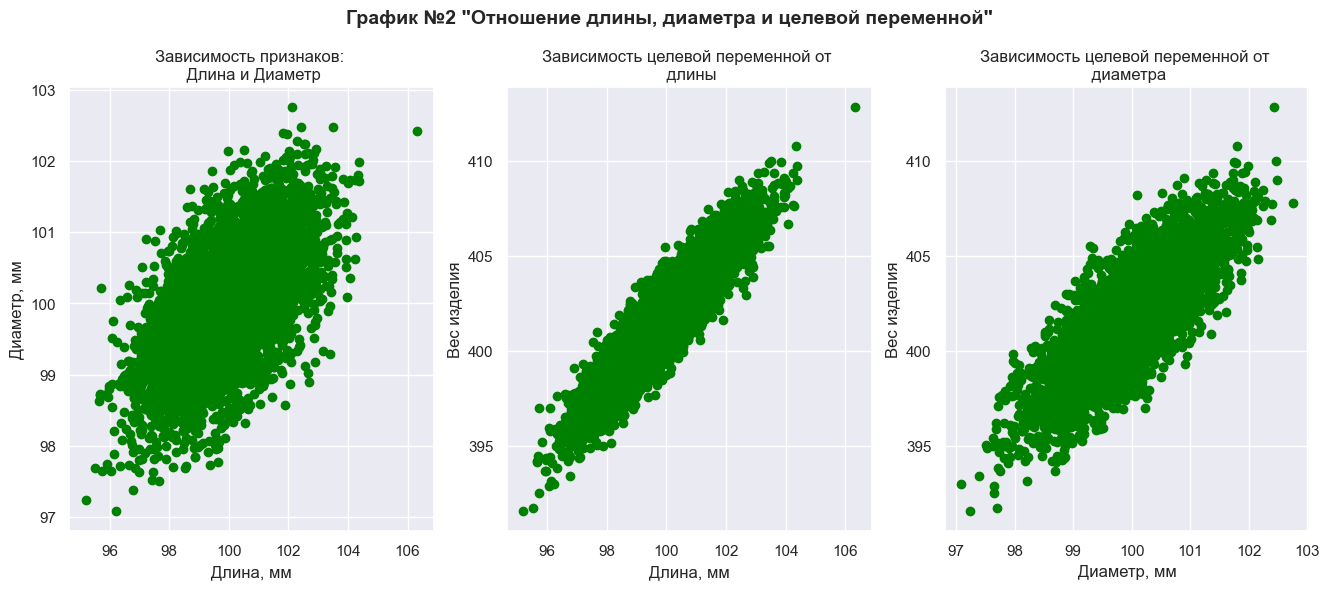

In [7]:
# формируем графики отображения зависимости признаков "Длина", "Диаметр" и целевой переменной "Вес изделия"
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 6))

fig.suptitle('График №2 "Отношение длины, диаметра и целевой переменной"', fontsize=14, fontweight='bold')
fig.subplots_adjust(top = 0.85)

ax1.scatter(dataframe['Длина, мм'],dataframe['Диаметр, мм'], color = 'green')
ax1.set_title('Зависимость признаков: \n Длина и Диаметр')
ax1.set_xlabel('Длина, мм')
ax1.set_ylabel('Диаметр, мм')

ax2.scatter(dataframe['Длина, мм'],dataframe['Вес изделия'], color = 'green')
ax2.set_title('Зависимость целевой переменной от \n длины')
ax2.set_xlabel('Длина, мм')
ax2.set_ylabel('Вес изделия')

ax3.scatter(dataframe['Диаметр, мм'],dataframe['Вес изделия'], color = 'green')
ax3.set_title('Зависимость целевой переменной от \n диаметра')
ax3.set_xlabel('Диаметр, мм')
ax3.set_ylabel('Вес изделия')

plt.show()

In [8]:
# инициируем таблицу ошибок среднеквадратичных отклонений
table_errors_test = pd.DataFrame(index = ['MSE'])

# напишем функцию определения среднеквадратичной ошибки
def error(x_train, x_test, y_train, y_test):
    # инициируем модель линейной регрессии
    model = LinearRegression()
    # обучим модель на обучающей выборке
    model_fit = model.fit(x_train,y_train)
    # сформируем вектор прогнозных значений
    y_pred = model_fit.predict(x_test)
    # определим среднеквадратичную ошибку
    error = round(mean_squared_error(y_test, y_pred),3)
    return error

# разделим выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# проведем центрирование данных (функция нормирования отключена)
scaler = StandardScaler(with_mean = True, with_std = False)
scaler = scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

# инициируем модель PCA с 4 компонентами
model_pca = PCA(n_components = 4)
# обучим модель на обучающей выборке
model_pca.fit(X_train_norm)
# преобразуем данные обучающей выборки
Z_train_norm = model_pca.transform(X_train_norm)
# преобразуем данные тестовой выборки
Z_test_norm = model_pca.transform(X_test_norm)

# сформируем в pandas таблицу оценок качества модели линейной регрессии в зависимости от используемых признаков
table_errors_test['Все признаки'] = error(X_train_norm, X_test_norm, y_train, y_test)
table_errors_test['3-и признака'] = error(X_train_norm[:,0:3], X_test_norm[:,0:3],y_train, y_test)
table_errors_test['Длина + Диаметр'] = error(X_train_norm[:,0:2], X_test_norm[:,0:2],y_train, y_test)
table_errors_test['Длина'] = error(X_train_norm[:,0].reshape(-1,1), X_test_norm[:,0].reshape(-1,1),
                                   y_train, y_test)
table_errors_test['Диаметр'] = error(X_train_norm[:,1].reshape(-1,1), X_test_norm[:,1].reshape(-1,1),
                                     y_train, y_test)
table_errors_test['Все компоненты'] = error(Z_train_norm, Z_test_norm, y_train, y_test)
table_errors_test['Три компоненты'] = error(Z_train_norm[:,0:3], Z_test_norm[:,0:3], y_train, y_test)
table_errors_test['Две компоненты'] = error(Z_train_norm[:,0:2], Z_test_norm[:,0:2], y_train, y_test)
table_errors_test['Первая компонента'] = error(Z_train_norm[:,0].reshape(-1,1),
                                               Z_test_norm[:,0].reshape(-1,1),
                                               y_train, y_test)


print ('Таблица №1 "Сравнение качества модели линейной регрессии, обученной на различных признаках"')
table_errors_test

Таблица №1 "Сравнение качества модели линейной регрессии, обученной на различных признаках"


,Все признаки,3-и признака,Длина + Диаметр,Длина,Диаметр,Все компоненты,Три компоненты,Две компоненты,Первая компонента
MSE,0.323,0.33,0.362,1.196,2.696,0.323,0.323,0.345,0.561


In [9]:
# формируем таблицу основных описательных статистик исходного пространства
X_train_dataframe = pd.DataFrame(X_train_norm)
X_train_dataframe.columns = columns_x
X_df_describe = X_train_dataframe.describe(percentiles = []).round(3)


# формируем матрицу преобразованного пространства
Z_train_norm = model_pca.transform(X_train_norm)
Z_train_dataframe = pd.DataFrame(Z_train_norm)
columns_z = ['1-я компонента','2-я компонента', '3-я компонента','4-я компонента']
Z_train_dataframe.columns = columns_z

# формируем таблицу основных описательных статистик исходного пространства
Z_df_describe = Z_train_dataframe.describe(percentiles = []).round(3)

# формируем сравнительную таблицу основных описательных статистик двух признаковых пространств
df_describe = pd.concat((X_df_describe, Z_df_describe), axis = 1)
columns_xz = columns_x + columns_z
columns_xz

print ('Таблица №2 "Сравнение значений основных описательных статистик исходного и преобразованного пространства"')
df_describe[columns_xz]

Таблица №2 "Сравнение значений основных описательных статистик исходного и преобразованного пространства"


,"Длина, мм","Диаметр, мм",3-й признак,4-й признак,1-я компонента,2-я компонента,3-я компонента,4-я компонента
count,3350.000,3350.000,3350.000,3350.000,3350.000,3350.000,3350.000,3350.000
mean,0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000
std,1.424,0.810,0.571,0.335,1.527,0.631,0.559,0.282
min,-4.764,-2.904,-1.191,-1.032,-5.453,-2.061,-1.052,-0.564
50%,-0.016,-0.002,0.003,-0.005,-0.017,-0.003,-0.003,0.004
max,6.368,2.486,1.120,0.956,6.838,2.132,1.102,0.598


In [10]:
# Сравним матрицы ковариаций
# формируем матрицу ковариации исходных признаков
X_df_cov = X_train_dataframe.cov().round(3)

# формируем матрицу ковариации преобразованных признаков
Z_df_cov = Z_train_dataframe.cov().round(3)

# формируем сравнительную таблицу ковариаций
df_cov = pd.concat((X_df_cov, Z_df_cov), axis = 1)

print ('Таблица №3 "Сравнение матрицы ковариации исходных и преобразованных признаков"')
df_cov[columns_xz].fillna('-')

Таблица №3 "Сравнение матрицы ковариации исходных и преобразованных признаков"


,"Длина, мм","Диаметр, мм",3-й признак,4-й признак,1-я компонента,2-я компонента,3-я компонента,4-я компонента
"Длина, мм",2.028,0.675,0.152,0.137,-,-,-,-
"Диаметр, мм",0.675,0.656,0.054,0.137,-,-,-,-
3-й признак,0.152,0.054,0.326,0.007,-,-,-,-
4-й признак,0.137,0.137,0.007,0.112,-,-,-,-
1-я компонента,-,-,-,-,2.332,-0.0,0.0,-0.0
2-я компонента,-,-,-,-,-0.0,0.399,-0.0,-0.0
3-я компонента,-,-,-,-,0.0,-0.0,0.312,0.0
4-я компонента,-,-,-,-,-0.0,-0.0,0.0,0.079


Действительно, мы наблюдаем некое перераспределение дисперсии признакового пространства в компоненты преобразованного.

В теории, дисперсии должны перераспределяться следующим образом. Первая компонента объясняет максимум
изменчивости исходных переменных, то есть имеет большую дисперсию, вторая – максимум оставшейся изменчивости и т.д., при этом все компоненты должны быть декоррелированны друг к другу.

В целом нечто похожее мы и наблюдаем.

Можно обратить внимание еще и на то, что после преобразования, информация с точки зрения сохранности дисперсии у нас никуда не девается — сумма дисперсий признаков исходного и преобразованного пространств полностью совпадает.

In [11]:
# сравним суммы дисперсий на исходном и преобразованном пространстве
print (round(sum(X_train_dataframe.var()), 3), '- Сумма дисперсий исходных признаков')
print (round(sum(Z_train_dataframe.var()),3), '- Сумма дисперсий преобразованных признаков')
print ()
print ('Значимость компонент:')
print (list(map(lambda x: round(x,3), model_pca.explained_variance_ratio_)))

3.122 - Сумма дисперсий исходных признаков
3.122 - Сумма дисперсий преобразованных признаков

Значимость компонент:
[0.747, 0.128, 0.1, 0.025]


Значимость компонент означает всего лишь долю дисперсии компоненты в сумме дисперсий компонент.

Кстати, заметим, что компоненты расположены в порядке убывания значений их дисперсий. Таким образом, наиболее значимые для анализа данных компоненты, всегда расположены в первых рядах.

Ранее, мы говорили о том, что преобразованное пространство полностью декоррелированно. Давайте убедимся в этом.

In [12]:
# формируем таблицу корреляции исходных признаков
X_df_cor = X_train_dataframe.corr().round(3)

# формируем таблицу корреляции преобразованных признаков
Z_df_cor = Z_train_dataframe.corr().round(3)

# формируем сравнительную таблицу корреляции
df_cor = pd.concat((X_df_cor, Z_df_cor), axis = 1)
# df_cor.fillna(0)

print ('Таблица №4 "Сравнение корреляции исходных и преобразованных признаков"')
df_cor[columns_xz].fillna('-')

Таблица №4 "Сравнение корреляции исходных и преобразованных признаков"


,"Длина, мм","Диаметр, мм",3-й признак,4-й признак,1-я компонента,2-я компонента,3-я компонента,4-я компонента
"Длина, мм",1.0,0.586,0.187,0.288,-,-,-,-
"Диаметр, мм",0.586,1.0,0.116,0.504,-,-,-,-
3-й признак,0.187,0.116,1.0,0.038,-,-,-,-
4-й признак,0.288,0.504,0.038,1.0,-,-,-,-
1-я компонента,-,-,-,-,1.0,-0.0,0.0,-0.0
2-я компонента,-,-,-,-,-0.0,1.0,-0.0,-0.0
3-я компонента,-,-,-,-,0.0,-0.0,1.0,0.0
4-я компонента,-,-,-,-,-0.0,-0.0,0.0,1.0


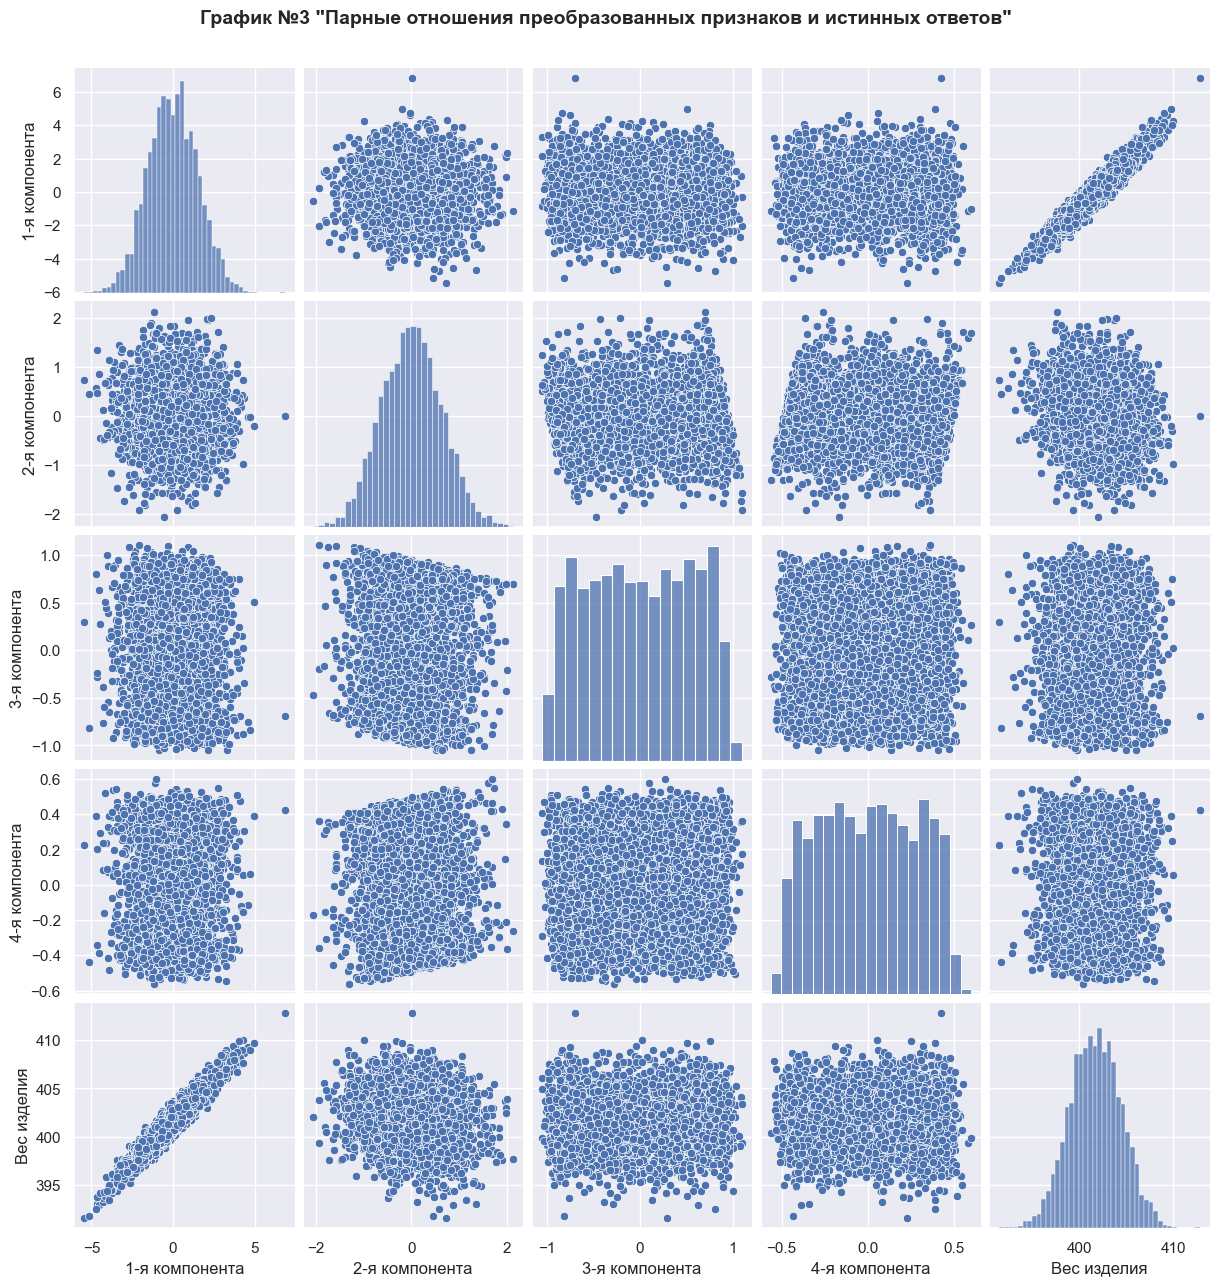

In [13]:
# Визуализируем отношения признаков и истинных ответов в преобразованном пространстве
Z_y_train_dataframe = pd.DataFrame(np.hstack((Z_train_norm,y_train)))
Z_y_train_dataframe.columns = columns_z + ['Вес изделия']
sns_plot = sns.pairplot(Z_y_train_dataframe)
sns_plot.fig.suptitle('График №3 "Парные отношения преобразованных признаков и истинных ответов"',
                      y = 1.03, fontsize=14, fontweight='bold')
plt.show()

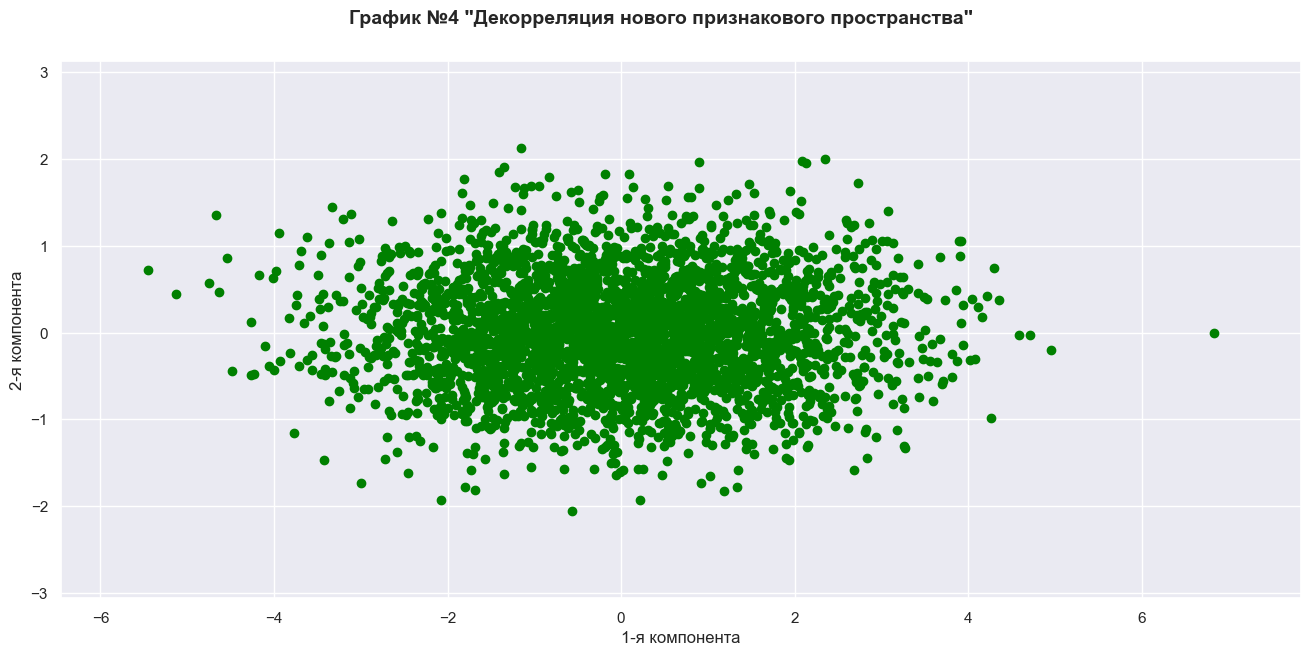

In [14]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 1, 1, aspect = 'equal')
ax.grid(True, which='both')

fig.suptitle('График №4 "Декорреляция нового признакового пространства"', fontsize=14, fontweight='bold')
fig.subplots_adjust(top = 1.05)

ax.set_ylim(np.min(Z_train_norm[:,1])-1, np.max(Z_train_norm[:,1])+1)
ax.set_xlim(np.min(Z_train_norm[:,0])-1, np.max(Z_train_norm[:,0])+1)
ax.plot(Z_train_norm[:,0], Z_train_norm[:,1], 'o', color = 'green')
plt.xlabel('1-я компонента')
plt.ylabel('2-я компонента')
plt.show()

Итак, наш пример подошел к завершению.

Мы воочию убедились, что метод главных компонент позволяет преобразовывать данные таким образом, что для обучения машинных алгоритмов (в нашем случае, модель линейной регрессии), можно использовать меньшее количество преобразованных признаков — компонент, относительно исходного пространства.

Это достигается за счет:

— перераспределения дисперсии, отражающей уровень информативности данных

— полной декорреляции исходного пространства

## Под капотом алгоритма

Переходим сразу к делу. Для проведения преобразований, нам требуется умножить матрицу исходного признакового пространства $X$ на некую матрицу $W$ (собственная матрица ковариационной матрицы) и получить новое признаковое пространство $Z$, такое, в котором:

— во-первых, новые признаки — компоненты декоррелированны между собой;

— во-вторых, сумма дисперсий значений компонент равняется сумме дисперсий значений исходных признаков;

— в-третьих, на главной диагонали матрицы ковариации расположены дисперсии компонент в порядке убывания от большего к меньшему.

Для выполнения вышеуказанных условий и для упрощения последующих рассчетов нам следует задать одно важно условие касательно матрицы $W$. Она должна быть ортогональна. Другими словами матрица $W$ — квадратная, $W^{-1}=W^T$, а также $W^TW=WW^T=I$, где $I$ — единичная матрица. Напомним, что единичной матрицей называют квадратную матрицу, у которой элементы главной диагонали равны единице поля, а остальные — нулю.

Запишем преобразование в матричном виде:

$\begin{equation*} \begin{cases} XW = Z \\ W^TW = I \end{cases} \end{equation*} $



По правилам хорошего тона укажем размерность матриц:

Матрица $X$ имеет размерность ($n$ x $m$)

Матрица $W$ — ($m$ x $m$)

Матрица $Z$ — ($n$ x $m$)

Матрица $I$ — ($m$ x $m$)

Обратим внимание на то, что матрица $W$ в такой системе уравнений может быть только квадратной и иметь размерность ($m$ x $m$), а следовательно, и матрица $Z$ будет иметь такую же размерность как матрица $X$. Однако, если мы хотим понизить размерность, то мы должны использовать не всю матрицу $W$, а только то количество столбцов, сколько признаков в преобразованном в пространстве мы желаем получить. Но для того, чтобы использовать выборочное количество столбцов матрицы $W$, мы для начала должны вычислить ее полностью.

Не знаю, насколько данная запись будет понятна читателю, но лично мне кажется логичной запись:

$\begin{equation*} \begin{cases} XW^d = Z^d \\ W^{D^T}W^D = I^D \end{cases} \end{equation*} $



Понятно, что $W^d$ имеет размерность $d$, а $W^D$ — $D$, при этом если мы не желаем понижать размерность, то $d$ и $D$ будут совпадать.

In [44]:
np.random.seed(0)
# инициализируем математическое ожидание двух случайных величин
mu = np.array((0.,0.))
# инициализируем матрицу ковариации двух случайных величин
cov = cov
# инициализируем количество объектов
N = 5000
# формируем матрицу признаков с параметрами mu и cov
X = np.dot(np.random.randn(N, 2), cov) + mu

In [45]:
X_real = pd.DataFrame(X).copy()
columns_mini = ['Длина','Диаметр']
X_real.columns = columns_mini
X_real.shape

(5000, 2)

In [46]:
# выполним нормализацию случайных величин для дальнейшего расчета ковариационной матрицы
mean_val_vect = (X[:,0].mean(), X[:,1].mean())
X[:,0] = X[:,0] - mean_val_vect[0]
X[:,1] = X[:,1] - mean_val_vect[1]

In [47]:
# зафиксируем матрицу признаков в таблице pandas
X_df = pd.DataFrame(X)
columns_mini = ['Длина','Диаметр']
X_df.columns = columns_mini
X_df.shape

(5000, 2)

Размерность матрицы $X$ составляет ($5000$ x $2$), а значит полная размерность матрицы $W$: ($2$ x $2$)

Теперь, когда мы получили систему уравнений и выяснили, что нам нужно найти матрицу $W$, нам следует ответить на вопрос — как главное уравнение связано с принципом максимизации дисперсии, да и вообще — с дисперсией? А самое важное — понять, как вычислять матрицу $W$ с учетом принципа максимизации дисперсии?

**Связка линейного преобразования исходного признакового пространства с принципом максимизации дисперсии через матрицу ковариации $Z$**

Давайте сделаем следующий трюк. Вместо поиска матрицы $Z$ будем определять матрицу ковариации $\Lambda$ матрицы $Z$, тогда:

$\Lambda = Cov(Z) = Z^TZ = (XW)^TXW = W^TX^TXW$

Для любителей более подробных математических выкладок есть еще один способ:

$\Lambda = Cov(Z) = Z^TZ = \frac{1}{N}(Z-\mu_Z)^T(Z-\mu_Z) = \frac{1}{N}(XW - \mu_XW)^T(XW - \mu_XW) = $

$ = \frac{1}{N}W^T(X-\mu_X)^T(X-\mu_X)W = \frac{1}{N}W^TX^TXW $

Обратим внимание на некоторые отличия в подходах. Первое уравнение в виде матричной записи предполагает, что матрица $X$ предварительно была отцентрирована ($X - \mu_X$) и определенные в ходе решения уравнения десперсии как будто по умолчанию усредненны ($\frac{1}{N}$). Второе уравнение раскрывает эти моменты и предполагает необходимость проведения их в процессе решения.

Запишем получившуюся систему уравнений:

$ \begin{equation*} \begin{cases} W^TX^TXW = \Lambda \\ W^TW = I \end{cases} \end{equation*} $



Надеюсь, все уловили, что мы не просто преобразовали уравнение $XW=Z$, мы по сути изменили задачу, так как теперь вместо матрицы $Z$ мы хотим получить $Z^TZ$.

С размерностью матриц в данной системе уравнений такая же ситуация как и в системе, указанной выше. Матрица $W$ по определению квадратная, но если мы желаем понизить размерность, то для начала мы вычисляем полную матрицу $W$, а затем берем только то количество столбцов, сколько признаков-компонент в новом пространстве мы хотим оставить.

Посмотрим на цифры из нашего примера, при условии того, что мы не хотим понижать размерность преобразованных данных. Тогда размерность матрицы $\Lambda$ составит: ($2$ x $2$) $\centerdot$ ($2$ x $5000$) $\centerdot$ ($5000$ x $2$) $\centerdot$ ($2$ x $2$) = ($2$ x $2$)
Самое время перейти к решению системы уравнений.

**Метод множителей Лагранжа**

Не будем заниматься обоснованием и доказательством метода, обозначим лишь, что данный метод является универсальным при поиске условных экстремумов. Действительно, у нас есть условие ортогональности матрицы $W$: $W^TW = I$ и есть желание найти экстремумы — значения матрицы $W$, при которых элементы главной диаганоли ковариационной матрицы $Z$ — дисперсии в преобразованном пространстве, максимальны.

В соответствии с методом множителей Лагранжа, систему уравнений с условием можно записать как функцию Лагранжа:

$L = f(W) + \lambda \centerdot \varphi(W)$

, где $f(W)$ — главное уравнение системы

$\varphi(W)$ — уравнение связи приравненное к нулю

$\lambda$ — множитель Лагранжа

Для перехода нашей системы уравнений в функцию Лагранжа:

— Во-первых, представим матричное выражение $W^TX^TXW$ в виде функции $f(W)$, то есть $f(W) = W^TX^TXW$.

— Во-вторых, уравнение связи об ортогональности матрицы $W$: $W^TW$ представим в виде функции $\varphi(W)$ и приравняем ее к нулю.

— В-третьих, осуществим некоторые уточнения. С этими уточнениями можно будет подробно ознакомиться буквально через абзац. А пока смотрим на функцию Лагранжа, которая у нас получилась:

$L=\vec{w_j^T}X^TX\vec{w_j} - \lambda_j(\vec{w_j^T}\vec{w_j}-1)$



В функции Лагранжа у нас не известны $\vec{w_j}$ и множитель Лагранжа — $\lambda_j$. И именно этот множитель мы будем находить в первую очередь, а после перейдем к поиску $\vec{w_j}$.

Теперь, как и было обещано, подробности об уточнениях.

В очередной раз прибегнем к такому трюку, как к замене задачи. В этот раз мы будем определять матрицу $W$ не целиком, а по столбцам, то есть для начала, как будто, будем искать каждый ее столбец и после того как определим все столбцы, то соберем и матрицу целиком. Другими словами, мы представляем матрицу $W$ как совокупность векторов $\vec{w_j}$, и следовательно матрицу $\Lambda$ представим как совокупность $\lambda_j$. Запишем эти изменения:

$\begin{equation*} \begin{cases} W^TX^TXW = \Lambda \\ W^TW = I \end{cases} \quad \Longrightarrow \quad \begin{cases} \vec{w_j^T}X^TX\vec{w_j} = \lambda_j \\ \vec{w_j^T}\vec{w_j} = 1 \end{cases} \end{equation*}$



Такая запись задачи дает нам удобство в дальнейших рассчетах. Ведь раннее нам требовалось для приравнивания $\varphi(W)$ к нулю вычислять $(I - W^TW)$. Использование единичной матрицы $I$ в расчетах не очень удобно. В результате такого изменения задачи, нам потребуется использовать вместо единичной матрицы в расчетах простое число — единицу, а значит $\varphi(W) =1 - \vec{w^T_j} \vec{w_j} = 0$

Запишем размерность главного выражения для каждого $j$-го случая в нашем примере: ($1$ x $2$) $\centerdot$ ($2$ x $5000$) $\centerdot$ ($5000$ x $2$) $\centerdot$ ($2$ x $1$) = $const$. То есть $\lambda_j$ это $const$, какое-то конкретное число. Интутивно мы понимаем, что $\lambda_j$ — это дисперсия или $j$-ый элемент главной диагонали ковариационной матрицы $\Lambda$. В том, что $\lambda_j$ — это $j$-ая дисперсия матрицы $\Lambda$ в статье мы доказывать не будем, но будьте уверены — интуиция нас не подводит.

Давайте, подумаем, что мы будем делать с функцией Лагранжа?

$ L=\vec{w_j^T}X^TX\vec{w_j} - \lambda_j(\vec{w_j^T}\vec{w_j}-1) $

Верно — мы будем ее дифференцировать по $\vec{w_j}$.

**Переход от задачи дифференцирования функции Лагранжа по вектору $\vec{w_j}$ к задаче поиска собственных значений $ \lambda_j $ и собственных векторов $\vec{w_j}$ матрицы $X^TX$**


Опустим подробности матричного дифференцирования за рамки статьи и перейдем сразу же к результату:

$\frac{dL}{d\vec{w_j}} \quad = \quad \frac{(\vec{w_j^T}X^TX\vec{w_j} - \lambda_j(\vec{w_j^T}\vec{w_j}-1))'}{(\vec{w_j})'} \quad   = \quad   2X^TX\vec{w_j} - 2\lambda_j\vec{w_j}$



Приравняем производную к нулю:
$2X^TX\vec{w_j} - 2\lambda_j\vec{w_j} = 0 \quad  \Longrightarrow \quad  X^TX\vec{w_j} = \lambda_j\vec{w_j}$



Таким образом, у нас возникла ситуация, когда квадратная матрица $X^TX$, умноженная на вектор $\vec{w_j}$ преобразовалась во всё тот же вектор $\vec{w_j}$, только дополнительно он еще и умноженный на некую константу $\lambda_j$. Из курса высшей математики, мы знаем, что при умножении некоторой квадратной матрицы на ненулевой вектор получается все тот же не нулевой вектор с некоторым коэффициентом, то такой вектор называется собственным вектором данной матрицы, а коэффициент — собственным числом матрицы.

В очередной раз в этой статье мы уточняем задачу. В этот раз вместо поиска векторов $\vec{w_j}$ и чисел $\lambda_j$ нам предстоить искать собственные вектора $\vec{w_j}$ и собственные числа $\lambda_j$ матрицы $X^TX$.

**Аналитическое решение: поиск собственных значений и собственных векторов матрицы $X^TX$**

Итак, мы имеем выражение $X^TX\vec{w_j} = \lambda_j\vec{w_j} $, в нем нам нужно найти собственные вектора $\vec{w_j}$ и собственные числа $\lambda_j$ матрицы $X^TX$

Давайте определим матрицу $X^TX$ для нашего частного случая

In [48]:
print ('Таблица №5 "Матрица XTX"')
# рассчитаем матрицу ковариации X и запишем результат в таблицу pandas
#
X_df_cov = pd.DataFrame(np.dot(X.T,X)/(N-1), index = columns_mini)
X_df_cov.columns = columns_mini
X_df_cov

Таблица №5 "Матрица XTX"


,Длина,Диаметр
Длина,2.002193,0.649202
Диаметр,0.649202,0.639335


**Проверим вычисления с помощью библиотеки numpy**

In [49]:
# по умолчанию bias=False, что соответствует N-1. Если bias=True, тогда количество степеней свободы равно N.
# bias=True используется для генеральной совокупности.
np.cov(X.T)

array([[2.00219322, 0.64920207],
       [0.64920207, 0.63933538]])

**В первую очередь определяем собственные числа (значения) матрицы $X^TX$**

Ненулевой вектор, который при умножении на некоторую квадратную матрицу превращается в самого же себя с числовым коэффициентом $\lambda$, называется собственным вектором матрицы. Число $\lambda$ называют собственным значением или собственным числом данной матрицы.

Выполним алгебраические действия — умножим матрицу на вектор:

$\begin{pmatrix} 2.0033 w_{1j} + 0.6496 w_{2j} \\ 0.6496 w_{1j} + 0.6394 w_{2j} \end{pmatrix} = \begin{pmatrix} \lambda_j w_{1j} \\ \lambda_j w_{2j} \end{pmatrix} \qquad$

Приравняем соответствующие элементы векторов-столбцов и получим однородную систему линейных уравнений:

$\begin{equation*} \begin{cases} 2.0033 w_{1j} + 0.6496 w_{2j} = \lambda_j w_{1j} \\ 0.6496 w_{1j} + 0.6394 w_{2j} = \lambda_j w_{2j} \end{cases} \quad \Longrightarrow \quad \begin{cases} 2.0033 w_{1j} + 0.6496 w_{2j} - \lambda_j w_{1j} = 0 \\ 0.6496 w_{1j} + 0.6394 w_{2j} - \lambda_j w_{2j} = 0 \end{cases} \end{equation*} $

Сделаем ход конем: в верхнем уравнении вынесем за скобку $w_{1j}$, во втором — $w_{2j}$:

$\begin{equation*} \begin{cases} (2.0033 - \lambda_j)w_{1j} + 0.6496 w_{2j} = 0 \\ 0.6496 w_{1j} + (0.6394 - \lambda_j) w_{2j} = 0 \end{cases} \end{equation*}$


По определению собственный вектор $\vec{w_j}$ не может быть нулевым, то есть $w_{1j} \neq w_{2j} \neq 0$. Из этого следует, что уравнения линейно зависимы и тогда определитель матрицы системы равен нулю:
$\left| \begin{array}{} 2.0033 - \lambda_j & 0.6496 \\ 0.6496 & 0.6394 - \lambda_j \\ \end{array} \right| = 0$

Раскроем определитель:
$(2.0033-\lambda_j)(0.6394 - \lambda_j) -0.6496 \cdot 0.6496 = 0\\$
$\lambda^2_j - 2.6427\lambda_j + 0.8589 = 0$

И решим квадратное уравнение вида:
$ax^2 + bx + c = 0$

Вычислим значение дискриминанта по $D$ формуле:
$D = b^2−4ac \\$
$D = 3.5483 \\$
$\sqrt{D} \approx 1.8837$

Дискриминант положительный, найдем два действительных корня квадратного уравнения по формуле:
$\lambda = \frac{-b±\sqrt{D}}{2 \cdot a}\\$

$\lambda_{1} = 2.2632, \lambda_{2} = 0.3795$

Половина дела завершена — мы нашли собственные значения матрицы $X^TX$. Раннее, мы делали интуитивное предположение, что собственные значения матрицы $X^TX$, это не что иное, как дисперсии преобразованного признакового пространства. Тогда, с учетом того, что метод главных компонент сохраняет дисперсию исходного пространства в преобразованном пространстве, мы можем сверить сумму собственных значений (равно сумму дисперсий преобразованного пространства) с суммой дисперсий исходного пространства. Мы ожидаем увидеть знак равенства между этими величинами.

Сумма дисперсий в исходном признаковом пространстве составляет: $2.0033 + 0.6394 = 2.6427$.

Сумма дисперсий в преобразованном пространстве: $2.2632 + 0.3795 = 2.6427$

Суммы совпадают, а значит мы на верном пути. Переходим к поиску собственных векторов $\vec{w_j}$.

In [50]:
VarX = X_df_cov.iat[0,0]
VarY = X_df_cov.iat[1,1]
CovXY = X_df_cov.iat[0,1]
print('VarX:', VarX)
print('VarY:', VarY)
print('CovXY:', CovXY)

VarX: 2.0021932150484063
VarY: 0.6393353846995291
CovXY: 0.6492020671610004


In [51]:
a = 1
b = - (VarX + VarY)
c = VarX * VarY - CovXY ** 2
print('b:', b)
print('c', c)

b: -2.6415285997479354
c 0.8586096453796437


In [52]:
disc = b**2 - 4 * a * c
disc

3.543234761767714

In [53]:
l_1 = (- b + np.sqrt(disc)) / (2 * a)
l_1

2.2619384019623796

In [54]:
l_2 = (- b - np.sqrt(disc)) / (2 * a)
l_2

0.3795901977855558

**Определяем собственные вектора матрицы $X^TX$**

Для определения собственных векторов нам надо по очереди в систему уравнений, приведенную ниже, подставить, полученные значения $\lambda$: $2.2632$ и $0.3795$:

$\begin{equation*} \begin{cases} (2.0033 - \lambda_j)w_{1j} + 0.6496 w_{2j} = 0 \\ 0.6496 w_{1j} + (0.6394 - \lambda_j) w_{2j} = 0 \end{cases} \end{equation*}$


Определим собственный вектор $\vec{w_j}$, соответствующий собственному числу $\lambda_{1} = 2.2632$:

$\begin{equation*} \begin{cases} -0.2599w_{11} + 0.6496 w_{21} = 0 \\ 0.6496 w_{11} - 1.6238w_{21} = 0 \end{cases} \end{equation*} $

$\begin{equation*} \begin{cases} -0.2599w_{11} = -0.6496 w_{21}   \\ 0.6496 w_{11} =  1.6238w_{21} \end{cases} \end{equation*} $

$\begin{equation*} \begin{cases} w_{11} = 2.4996 w_{21}  \\ w_{11} = 2.4996 w_{21} \end{cases} \end{equation*} $

Такая система уравнений имеет бесконечное множество решений, но главное здесь — соотношение между искомыми значениями $w_{1j}$ и $w_{2j}$. Оно должно составлять 2.4996. Хорошо, давайте тогда выберем пару значений:

$ \begin{equation*} \begin{cases} w_{11} = 2.4996 \\ w_{21} = 1.0000 \end{cases} \end{equation*} $

<a href='http://mathprofi.ru/sobstvennye_znachenija_i_sobstvennye_vektory.html'>Таким же образом</a>, определим собственный вектор, соответствующий собственному числу $\lambda_{2} = 0.3795$

$\begin{equation*} \begin{cases} 1.6238w_{11} + 0.6496 w_{21} = 0 \\ 0.6496 w_{11} + 0.2599w_{21} = 0 \end{cases} \end{equation*} $

$\begin{equation*} \begin{cases} 1.6238w_{11} = -0.6496 w_{21}   \\ 0.6496 w_{11} = - 0.2599w_{21} \end{cases} \end{equation*} $

$\begin{equation*} \begin{cases} w_{11} = - 0.4000 w_{21}  \\ w_{11} = - 0.40006 w_{21} \end{cases} \end{equation*} $

$ \begin{equation*} \begin{cases} w_{12} = -0.4000 \\ w_{22} = 1.0000 \end{cases} \end{equation*} $

В итоге, мы получили матрицу $W$, состоящую из собственных векторов.

$W = \begin{pmatrix} 2.4996 & -0.4000 \\ 1.0000 & 1.0000 \end{pmatrix} \qquad$

In [55]:
w_11 = CovXY  / -(VarX - l_1)
w_21 = 1
print(w_11)
print(w_21)

2.4993805462736596
1


In [56]:
w_12 = CovXY  / -(VarX - l_2)
w_22 = 1
print(w_12)
print(w_22)

-0.4000991371605678
1


Однако, это еще не совсем та матрица, которую мы искали. В ней могли быть совсем другие значения, конечно же с условием сохранения соотношений между $w_{1j}$ и $w_{2j}$. Так какую нам выбрать матрицу, какие значения в конечном итоге подставить? Ответ — выбираем нормированную матрицу. Опустим подробности рассуждения, почему нам требуется нормировка матрицы, упомянем лишь о том, что без нормирования матрицы $W$ не будет возможно выполнить условие ортогональности матрицы.

Для нормировки матрицы $W$, воспользуемся имеющейся в библиотеке numpy функцией linalg.norm(). Выберем настройки по умолчанию. Это будет норма Фробениуса.

In [57]:
W = np.array(([w_11, w_12],[w_21, w_22]))


def normalize_function(w):
    norm = np.linalg.norm(w, axis = 0)
    return w / norm


W_norm = normalize_function(W).round(4)
W_norm

array([[ 0.9284, -0.3715],
       [ 0.3715,  0.9284]])

In [58]:
print ('Проверка матрицы W на ортогональность: \n', np.dot(W_norm.T,W_norm).round(2))

Проверка матрицы W на ортогональность: 
 [[ 1. -0.]
 [-0.  1.]]


**Проверим вычисления с помощью библиотеки numpy**

In [59]:
# eig — это готовый метод numpy из библиотеки линейной алгебры
# найдем собственные значения и собственный вектор
eigenvalues, eigenvector = np.linalg.eig(X_df_cov)
print('eigenvalues:')
pd.DataFrame({'Manual': [l_1, l_2], 'Numpy': eigenvalues})

eigenvalues:


,Manual,Numpy
0,2.261938,2.261938
1,0.379590,0.379590


In [60]:
print('eigenvector:')
pd.DataFrame({'Manual_0': W_norm[:,0], 'Numpy_0': eigenvector[:,0], 'Manual_1': W_norm[:,1], 'Numpy_1': eigenvector[:,1]})

eigenvector:


,Manual_0,Numpy_0,Manual_1,Numpy_1
0,0.9284,0.928445,-0.3715,-0.371470
1,0.3715,0.371470,0.9284,0.928445


**Проверим, что у нас получилось**
1. Сформируем компоненту аналитическим способом
2. Сформируем компоненту с помощью sklearn
3. Сравним результаты и ключевые статистики

In [61]:
# используем собственный вектор, соответствующий большему собственному значению eigenvector[:, 0]
# в нашем примере eigenvalues[0] больше eigenvalues[1]. Поэтому используем W_norm[:, 0]
Z_component_1 = W_norm[:, 0].dot(X_df.T)

In [62]:
Z_component_1[:3]

array([2.61021936, 3.19107642, 1.5642501 ])

In [63]:
model_pca = PCA(n_components = 1)
model_pca.fit(X_df)
Z_component_1_pca = model_pca.transform(X_df)

In [64]:
# сравним значения полученных компонент с помощью аналитического метода и библиотеки numpy
compare = pd.DataFrame()
compare['Manual'] = Z_component_1
compare['Sklearn'] = Z_component_1_pca
compare.head(5)

,Manual,Sklearn
0,2.610219,2.610317
1,3.191076,3.191137
2,1.564250,1.564349
3,1.111346,1.111398
4,0.261438,0.261435


In [65]:
# сравним ключевые меры описательной статистики
compare.describe()

,Manual,Sklearn
count,5.000000e+03,5.000000e+03
mean,1.563194e-17,9.592327e-18
std,1.503928e+00,1.503974e+00
min,-5.441512e+00,-5.441643e+00
25%,-1.046747e+00,-1.046757e+00
50%,-5.025182e-03,-5.028289e-03
75%,1.034808e+00,1.034855e+00
max,6.818876e+00,6.819089e+00


In [66]:
# сравним ключевые характеристики метода PCA
# средние значения
print('Mean vector: ', model_pca.mean_, [X_df['Длина'].mean(), X_df['Диаметр'].mean()])
# значения собственного вектора
print('Projection: ', model_pca.components_, W_norm[:,0])
# объясненную дисперсию
print('Explained variance: ', model_pca.explained_variance_, l_1)
# объясненную долю дисперсии
print('Explained variance ratio: ', model_pca.explained_variance_ratio_, l_1 / (X_df_cov.iat[0,0] + X_df_cov.iat[1,1]))

Mean vector:  [2.75113266e-17 6.97220059e-18] [9.947598300641403e-18, 1.4210854715202004e-17]
Projection:  [[0.92844495 0.37147002]] [0.9284 0.3715]
Explained variance:  [2.2619384] 2.2619384019623796
Explained variance ratio:  [0.85629904] 0.8562990391920127


In [67]:
# восстановим первоначальную матрицу
X_restored_m = Z_component_1.reshape(len(Z_component_1), 1).dot(W_norm[:,0].reshape(1, len(W_norm[:,0]))) + mean_val_vect

In [68]:
# сравним значения истиной матрицы и восстановленной с помощью аналитического метода
compare = pd.concat([X_real, pd.DataFrame(X_restored_m)], axis=1)
compare.head(3)

,Длина,Диаметр,0,1
0,2.533362,0.584734,2.384884,0.955360
1,2.616895,1.939525,2.924152,1.171148
2,1.841459,-0.501689,1.413806,0.566782


In [69]:
X_restored_sk = Z_component_1_pca.reshape(len(Z_component_1_pca), 1).dot(model_pca.components_) + mean_val_vect

In [70]:
# сравним значения истиной матрицы и восстановленной с помощью sklearn
compare_sk = pd.concat([X_real, pd.DataFrame(X_restored_sk)], axis=1)
compare_sk.head(3)

,Длина,Диаметр,0,1
0,2.533362,0.584734,2.385092,0.955318
1,2.616895,1.939525,2.924352,1.171075
2,1.841459,-0.501689,1.413968,0.566772


In [71]:
# рассчитаем и сравним:
# Mean Abs: среднее абсолютное значение
# MAЕ: средняя абсолютная ошибка
# MAPE: средняя абсолютная ошибка в процентах
# Abs Sum: сумма абсолютных значений
# AE: MAЕ * кол-во наблюдений
total = pd.DataFrame(columns=['x_1', 'x_2'])
total.loc['Mean Abs', 'x_1'] = abs(compare['Длина']).sum()/len(compare)
total.loc['Mean Abs', 'x_2'] = abs(compare['Диаметр']).sum()/len(compare)
total.loc['MAE', 'x_1'] = mean_absolute_error(compare['Длина'], compare[0])
total.loc['MAE', 'x_2'] = mean_absolute_error(compare['Диаметр'], compare[1])
total.loc['MAPE', 'x_1'] = mean_absolute_percentage_error(compare['Длина'], compare[0])
total.loc['MAPE', 'x_2'] = mean_absolute_percentage_error(compare['Диаметр'], compare[1])
total.loc['Abs Sum', 'x_1'] = abs(compare['Длина']).sum()
total.loc['Abs Sum', 'x_2'] = abs(compare['Диаметр']).sum()
total.loc['AE', 'x_1'] = mean_absolute_error(compare['Длина'], compare[0]) * len(compare)
total.loc['AE', 'x_2'] = mean_absolute_error(compare['Диаметр'], compare[1]) * len(compare)

total_sk = pd.DataFrame(columns=['sk_x_1', 'sk_x_2'])
total_sk.loc['Mean Abs', 'sk_x_1'] = abs(compare_sk['Длина']).sum()/len(compare_sk)
total_sk.loc['Mean Abs', 'sk_x_2'] = abs(compare_sk['Диаметр']).sum()/len(compare_sk)
total_sk.loc['MAE', 'sk_x_1'] = mean_absolute_error(compare_sk['Длина'], compare_sk[0])
total_sk.loc['MAE', 'sk_x_2'] = mean_absolute_error(compare_sk['Диаметр'], compare_sk[1])
total_sk.loc['MAPE', 'sk_x_1'] = mean_absolute_percentage_error(compare_sk['Длина'], compare_sk[0])
total_sk.loc['MAPE', 'sk_x_2'] = mean_absolute_percentage_error(compare_sk['Диаметр'], compare_sk[1])
total_sk.loc['Abs Sum', 'sk_x_1'] = abs(compare_sk['Длина']).sum()
total_sk.loc['Abs Sum', 'sk_x_2'] = abs(compare_sk['Диаметр']).sum()
total_sk.loc['AE', 'sk_x_1'] = mean_absolute_error(compare_sk['Длина'], compare_sk[0]) * len(compare_sk)
total_sk.loc['AE', 'sk_x_2'] = mean_absolute_error(compare_sk['Диаметр'], compare_sk[1]) * len(compare_sk)

total = pd.concat([total, total_sk], axis=1)
total

,x_1,x_2,sk_x_1,sk_x_2
Mean Abs,1.135412,0.636923,1.135412,0.636923
MAE,0.182847,0.456942,0.182825,0.456949
MAPE,0.904986,3.698383,0.904951,3.69829
Abs Sum,5677.058021,3184.615902,5677.058021,3184.615902
AE,914.234754,2284.707788,914.125098,2284.746487


In [72]:
# сравним реальные значения и восстановленные обоими методами
total_compare = pd.concat([X_real, pd.DataFrame(X_restored_m), pd.DataFrame(X_restored_sk)], axis=1)
total_compare.head(5)

,Длина,Диаметр,0,1,0,1
0,2.533362,0.584734,2.384884,0.955360,2.385092,0.955318
1,2.616895,1.939525,2.924152,1.171148,2.924352,1.171075
2,1.841459,-0.501689,1.413806,0.566782,1.413968,0.566772
3,1.144301,0.021427,0.993330,0.398528,0.993428,0.398514
4,0.112175,0.312996,0.204275,0.082788,0.204284,0.082779
